<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S6_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required Libraries**


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# simple function to upload files from local drive

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

**Data Transformations**


* Here I've created a Class to transform Train & Test Data. And I'm using Compose function to chain in all the transform operations required in the form of list and then pass it on the different sets of data.
* I have already set the mean and the standard deviation to 0.1307 & 0.3081 
* 2 main parameters normalize(boolean) and rotate(default value = 0).


In [0]:
# # Transformations 

# class Transformations():

#   def __init__(self, normalize=True, rotate = 0):
#       self.normalize = normalize
#       self.rotate = rotate


#   # For Train Data
#   def train_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = []
#       transforms_list.append(transforms.ToTensor())
#       if self.normalize: 
#           transforms_list.append(transforms.Normalize((0.1307, ), (0.3081, )))
#       if self.rotate:
#           transforms_list.append(transforms.RandomRotation((-1*int(self.rotate), int(self.rotate)), fill=(1,)))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)


#   # For Test Data
#   def test_transforms(self, tensorToPIL = True):
#       self.tensorToPIL = tensorToPIL
#       transforms_list = [transforms.ToTensor()]
#       if self.normalize:
#           transforms_list.append(transforms.Normalize((0.1307, ),(0.3081, )))
#       if self.tensorToPIL:
#           transforms_list.append(transforms.ToPILImage())
#       return transforms.Compose(transforms_list)



# mnist_data = Transformations(normalize = True, rotate = 5)    # set normalize = True
# train_trans = mnist_data.train_transforms(tensorToPIL = True)  # Rotation of Train Images
# test_trans = mnist_data.test_transforms(tensorToPIL = True)

In [0]:
# Transformations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      #  transforms.ToPILImage()# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      #  transforms.ToPILImage()
                                       ])


In [0]:
# Split Test & Train Data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

**Dataloaders Arguments & Train/Test Dataloaders**

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 128):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

**Data Statistics**

torch.Size([128, 1, 28, 28])
torch.Size([128])


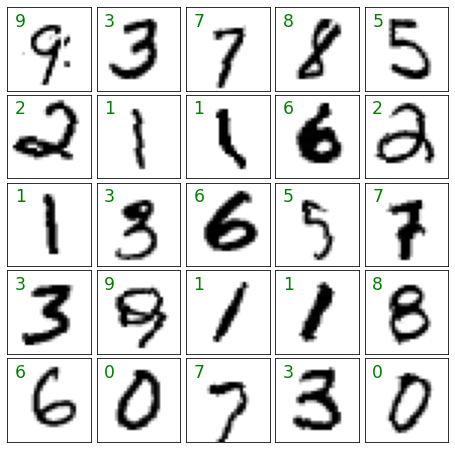

In [7]:

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape) # [64, 1, 28, 28]
print(labels.shape) # [64]


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


def display_25(images, labels):
  figmatrix = plt.figure(figsize=(8, 8))
  row, col = 5, 5 # set rows & columns = 5
  gs = gridspec.GridSpec(row, col)
  gs.update(wspace=0.005, hspace=0.05)

  for i in range(1, 26):
    plt.subplot(gs[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="green", fontsize="xx-large")
  plt.show()

display_25(images[:25], labels[:25])



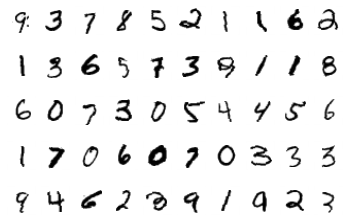

In [8]:
# Just curious at the orientation of these mnist images
figure = plt.figure()
num_of_images = 50
for i in range(1,num_of_images+1):
  plt.subplot(5,10, i)
  plt.axis('off')
  plt.imshow(images[i-1].numpy().squeeze(), cmap = 'gray_r')

In [0]:
# Main Model with Batch Normalization
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(8)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      



In [10]:
# BN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

**Model 1**
#without L1 and L2 regularization with BN


In [0]:
def withoutL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with BN')

  model1= Test_Train()
  # global loss1
  # global acc1
  loss1 = model1.test_losses
  acc1 = model1.test_acc

  EPOCHS = 5  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model1.train(model, device, train_loader, optimizer, epoch, scheduler)
      model1.test(model, device, test_loader,"model1.pt")



**Model 2**
#with L1 regularization with BN


In [0]:

def withL1_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#second model
  print('with L1 regularization with BN')

  model2 = Test_Train()
  # global loss2
  # global acc2
  loss2 = model2.test_losses
  acc2 = model2.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model2.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model2.test(model, device, test_loader,"model2.pt")

**Model 3**
#with L2 regularization with BN


In [0]:

def withL2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#third model
  print('with L2 regularization with BN')

  model3 = Test_Train()
  # global loss3
  # global acc3
  loss3 = model3.test_losses
  acc3 = model3.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model3.train(model, device, train_loader, optimizer, epoch, scheduler)
      model3.test(model, device, test_loader,"model3.pt")

**Model 4**
#with both L1 & L2 regularization with BN


In [0]:
def withL1_L2_BN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#fourth  model
  print('with L1 & L2 regularization with BN')

  model4 = Test_Train()
  # global loss4
  # global acc4
  loss4 = model4.test_losses
  acc4 = model4.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model4.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model4.test(model, device, test_loader,"model4.pt")

In [0]:
modelTuple = iter(withoutL1_L2_BN(),
  withL1_BN(),
  withL2_BN(),
  withL1_L2_BN())

print(modelTuple.__next__())

  0%|          | 0/469 [00:00<?, ?it/s]

without L1 and L2 regularization with BN
EPOCH: 1


Loss=0.04111553356051445 Batch_id=468 Accuracy=86.51: 100%|██████████| 469/469 [00:48<00:00,  9.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0782).  Saving model ...

Test set: Average loss: 0.0782, Accuracy: 9743/10000 (97.43%)

EPOCH: 2


Loss=0.09798085689544678 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0782 --> 0.0774).  Saving model ...

Test set: Average loss: 0.0774, Accuracy: 9746/10000 (97.46%)

EPOCH: 3


Loss=0.0688939169049263 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0774 --> 0.0365).  Saving model ...

Test set: Average loss: 0.0365, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.015699025243520737 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:48<00:00,  9.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0365 --> 0.0357).  Saving model ...

Test set: Average loss: 0.0357, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.03014279715716839 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:48<00:00,  9.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0357 --> 0.0277).  Saving model ...

Test set: Average loss: 0.0277, Accuracy: 9894/10000 (98.94%)

with L1 regularization with BN
EPOCH: 1


Loss=0.1037793904542923 Batch_id=468 Accuracy=88.22: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0975).  Saving model ...

Test set: Average loss: 0.0975, Accuracy: 9706/10000 (97.06%)

EPOCH: 2


Loss=0.11030608415603638 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0975 --> 0.0489).  Saving model ...

Test set: Average loss: 0.0489, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.06788524985313416 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:47<00:00,  9.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0489 --> 0.0431).  Saving model ...

Test set: Average loss: 0.0431, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.03394118323922157 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:50<00:00,  9.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0431 --> 0.0338).  Saving model ...

Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.07328779250383377 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9879/10000 (98.79%)

with L2 regularization with BN
EPOCH: 1


Loss=0.09526107460260391 Batch_id=468 Accuracy=86.34: 100%|██████████| 469/469 [00:49<00:00,  9.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 0.0610).  Saving model ...

Test set: Average loss: 0.0610, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.062306638807058334 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0610 --> 0.0496).  Saving model ...

Test set: Average loss: 0.0496, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


Loss=0.08219601213932037 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0496 --> 0.0438).  Saving model ...

Test set: Average loss: 0.0438, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.07597459107637405 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Validation loss has  decreased (0.0438 --> 0.0393).  Saving model ...

Test set: Average loss: 0.0393, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.0123362448066473 Batch_id=286 Accuracy=98.44:  61%|██████    | 287/469 [00:29<00:18,  9.80it/s]

In [0]:
# # Alternative method for running models (For BN)

# from torch.optim.lr_scheduler import OneCycleLR
# %matplotlib inline
# import matplotlib.pyplot as plt

# validation_acc = []
# validation_loss = []
# train_loss = []
# misclassified_img = []
# pred_class = []
# act_class = []


# # List - Tuple with L1 & L2 factors

# # L1 = 0.0005, L2 = 0.0001

# fact_tuple = [(0, 0), (0.0005 , 0), (0, 0.0001), (0.0005 , 0.0001)]


# for factors in fact_tuple:
#   model_name = 'model'+str(fact_tuple.index(factors))+'.pt'
#   L1_factor, L2_factor = factors
#   reg_factors = {'L1':L1_factor, 'L2':L2_factor}
  
#   train_losses = []
#   test_losses = []
#   train_acc = []
#   test_acc = []
#   train_acc_epoch = []
#   train_losses_epoch = []

#   actual_img = []
#   wrong_pred = []
#   target = []

#   model = Net.to(device)
#   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=L2_factor)
#   scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)


#   EPOCHS = 25
#   L1Lambda = L1_factor
#   for epoch in range(EPOCHS):
#     print('EPOCH: ',epoch)
#     train(model, device, train_loader, optimizer, scheduler, epoch, L1Lambda)
#     test(model, device, test_loader, model_name)

#     validation_acc.append(test_acc)
#     validation_loss.append(test_losses)
#     train_loss.append(train_losses_epoch)

#     print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
#            max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch)))

In [0]:
# Validation Accuracy 

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(acc1)
ax.plot(acc2)
ax.plot(acc3)
ax.plot(acc4)
ax.set(title="Model Validation Accuracy of 4 Models with Batch-Normalization", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4modelswithBN.png")
plt.show()



In [0]:
# Validation Loss 
plt.figure(figsize = (15,10))
ax = plt.subplot(111)
ax.plot(loss1)
ax.plot(loss2)
ax.plot(loss3)
ax.plot(loss4)
ax.set(title='Validation Losses of 4 Models', xlabel='Epoch', ylabel = 'Loss')
ax.legend(['without L1 & L2', 'with L1', 'with L2', 'with L1 & L2'], loc = 'best')
plt.savefig('ValidationLossesBN.png')
plt.show()


In [0]:
# Misclassified Images

from google.colab import files
def misclassifiedOnes(model, filename):
  model = model.to(device)
  dataiter = iter(test_loader) 
  count = 0
  fig = plt.figure(figsize=(13,13))

  while count<25:
      images, labels = dataiter.next()
      images, labels = images.to(device), labels.to(device)
    
      output = model(images) 
      _, pred = torch.max(output, 1)   # convert output probabilities to predicted class
      images = images.cpu().numpy() # conv images to numpy format

      for idx in np.arange(128):
        if pred[idx]!=labels[idx]:
          ax = fig.add_subplot(5, 5, count+1, xticks=[], yticks=[])
          count=count+1
          ax.imshow(np.squeeze(images[idx]), cmap='cool')
          ax.set_title("Pred-{} (Target-{})".format(str(pred[idx].item()), str(labels[idx].item())), color="yellow")
          if count==25:
            break
      plt.savefig(filename)
      files.download(filename)

   


In [0]:
print('Misclassifed Images from Model1')
print('*'*30)

model.load_state_dict(torch.load("model1.pt")) 
misclassifiedOnes(model,'withoutL1_L2_BN.png')
save_image()

In [0]:
print('Misclassifed Images from Model2')
print('*'*30)

model.load_state_dict(torch.load("model2.pt")) 
misclassifiedOnes(model,'withL1_BN.png')

In [0]:
print('Misclassifed Images from Model3')
print('*'*30)
model.load_state_dict(torch.load("model3.pt")) 
misclassifiedOnes(model,'withL2_BN.png')

In [0]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withL1_L2_BN.png')

In [0]:
# DataLoaders

class Dataloader:
  def __init__(self, shuffle = True, batch_size = 256):
      cuda = torch.cuda.is_available()
      if cuda:
        torch.cuda.manual_seed(seed)
      self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) #if cuda else dict(shuffle=True, batch_size=64)

  def dataset_loader(self, data):
      return torch.utils.data.DataLoader(data, **self.dataloader_args) # **dataloader_args get passed when dataset_loader gets called


dl = Dataloader()

# train dataloader
train_loader = dl.dataset_loader(train)

# test dataloader
test_loader = dl.dataset_loader(test)

In [0]:
# Main Model with Ghost Batch Normalization
# use diff batch size for GBN

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          GhostBatchNorm(8,2)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(10,2)) # O/P: 24

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 10
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 8
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          GhostBatchNorm(16,2)) # O/P: 6

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0,  bias = False))
         

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(4))

    
    # Last Layer
      self.convblock9 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.08))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      # x = self.drop(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock9(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)
      


# Ghost Batch Normalization

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0) # fill_() helps you filling up the tensor with a particular data
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




In [0]:
# GBN Model Summary 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modelGBN = Net().to(device)
summary(modelGBN, input_size=(1, 28, 28))

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
    
      self.test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Model 5

def withoutL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#first model
  print('without L1 and L2 regularization with GBN')
#without L1 and L2 regularization with GBN

  model5= Test_Train()
  # global loss1
  # global acc1
  loss5 = model5.test_losses
  acc5 = model5.test_acc

  EPOCHS = 5  
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model5.train(model, device, train_loader, optimizer, epoch, scheduler)
      model5.test(model, device, test_loader,"model5.pt")



In [0]:
# Model 6

def withL1_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#sixth model
  print('with L1 regularization with GBN')
#with L1 regularization with BN
  model6 = Test_Train()
  # global loss2
  # global acc2
  loss6 = model6.test_losses
  acc6 = model6.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model6.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model6.test(model, device, test_loader,"model6.pt")

In [0]:

def withL2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#seventh model
  print('with L2 regularization with GBN')
#with L2 regularization 
  model7 = Test_Train()
  # global loss3
  # global acc3
  loss7 = model7.test_losses
  acc7 = model7.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model7.train(model, device, train_loader, optimizer, epoch, scheduler)
      model7.test(model, device, test_loader,"model7.pt")

In [0]:


def withL1_L2_GBN():
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=25)

#eighth  model
  print('with L1 & L2 regularization with GBN')
#with both L1 & L2 regularization with BN
  model8 = Test_Train()
  # global loss4
  # global acc4
  loss8 = model8.test_losses
  acc8 = model8.test_acc

  EPOCHS = 5
  for epoch in range(1,EPOCHS+1):
      print("EPOCH:", epoch)
      model8.train(model, device, train_loader, optimizer, epoch, scheduler, L1lambda = 1e-5)
      model8.test(model, device, test_loader,"model8.pt")

In [0]:
modelTuple = iter(withoutL1_L2_GBN(),
  withL1_GBN(),
  withL2_GBN(),
  withL1_L2_GBN())

print(modelTuple.__next__())

In [0]:
print('Misclassifed Images from Model4')
print('*'*30)

model.load_state_dict(torch.load("model4.pt")) 
misclassifiedOnes(model,'withoutL1_L2_GBN.png')

In [0]:
print('Misclassifed Images from Model5')
print('*'*30)

model.load_state_dict(torch.load("model5.pt")) 
misclassifiedOnes(model,'withL1_GBN.png')

In [0]:
print('Misclassifed Images from Model7')
print('*'*30)

model.load_state_dict(torch.load("model7.pt")) 
misclassifiedOnes(model,'withL2_GBN.png')

In [0]:
print('Misclassifed Images from Model8')
print('*'*30)

model.load_state_dict(torch.load("model8.pt")) 
misclassifiedOnes(model,'withL1_L2_GBN.png')